<center>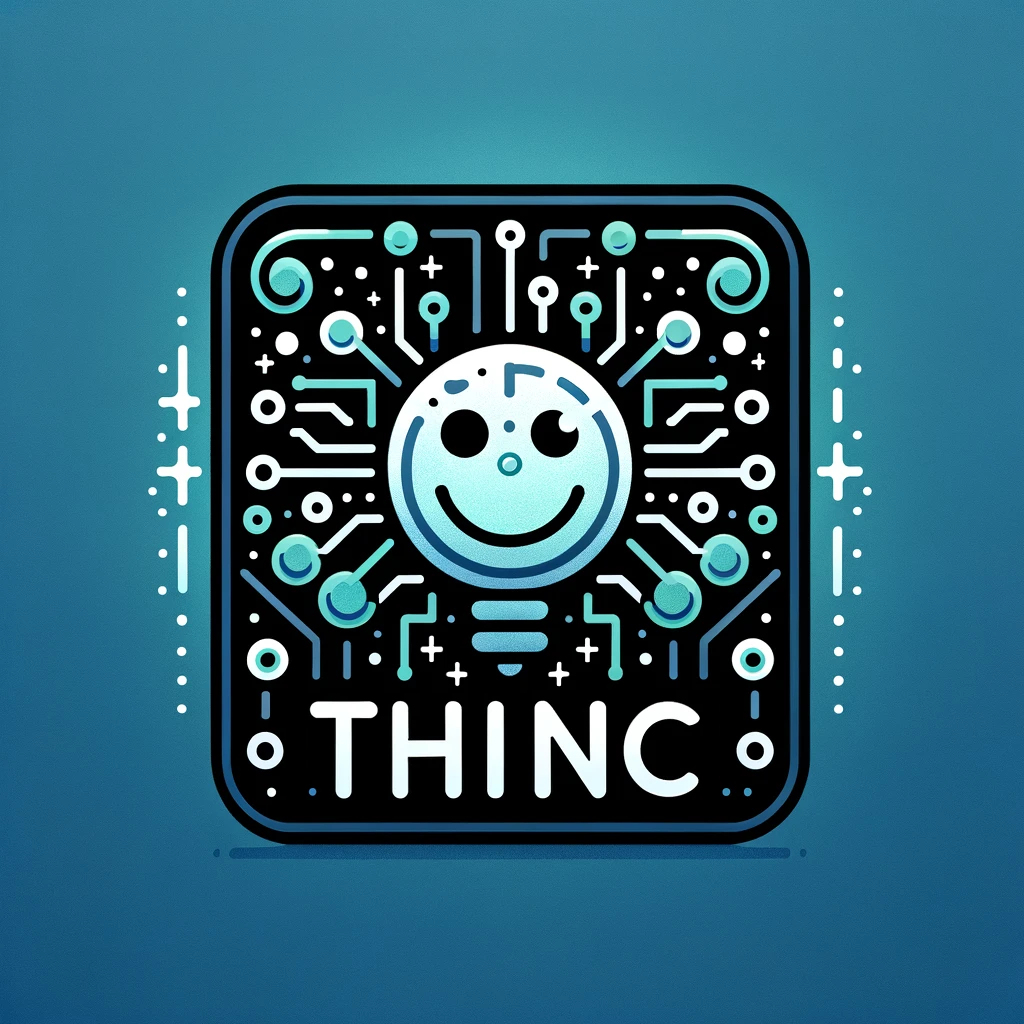</center>

<center><font size="1">Logo automatically generated by ChatGPT on 02/23/2024.</font></center>
    
<center><h1 style="color: #1C6185; font-weight:bold;">THInC: A Theory-Driven Framework for Computational Humor Detection</h1></center>

# 1. Required libraries and imports
In this section, the libraries that are required for the rest of this code will be loaded. Ensure you have installed all the needed libraries using `pip install -r requirements.txt`

In [97]:
# Required to load the datasets
import csv

# Required for feature calculations (Section 3)
from transformers import GPT2TokenizerFast, LlamaTokenizerFast, LlamaForCausalLM, RobertaTokenizerFast, RobertaForSequenceClassification, BertTokenizerFast, BertForSequenceClassification, DistilBertTokenizerFast, DistilBertForSequenceClassification
import torch
import numpy as np
import pandas as pd

# Required for saving calculations
import pickle
 
# Requred for ambiguity calculation (Section 3.1.g)
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize.destructive import NLTKWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import gensim.downloader as api
 
# Required for morphosyntactic ambiguity calculation (Section 3.1.h)
import spacy # You'll also need to run `python -m spacy download en_core_web_trf`

# Required for extracting numerical proxy features from time series (Section 3.2.2)
from tsfresh.feature_extraction.feature_calculators import *

# Required for creating the dataset for the benchmark classifier (Section 4.1.1)
from datasets import Dataset, DatasetDict

# Required for creating the modified language model head in the benchmark classifier (Section 4.1.2)
from typing import List, Optional, Tuple, Union
import torch.nn as nn
from transformers.models.roberta import RobertaForSequenceClassification
from transformers import RobertaModel
from transformers.modeling_outputs import SequenceClassifierOutput

# Required for training the benchmark classifier (Section 4.1.3)
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
import evaluate

# Required for evaluating the benchmark classifier (Section 4.1.4)
from transformers import pipeline
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

# Required for training the ensemble classifier (Section 4.2.2)
from math import comb
from interpret.glassbox import ExplainableBoostingClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from scipy import stats
from scipy.optimize import minimize
from sklearn.metrics import average_precision_score

# Required for interpreting the model (Section 4.2.4 and subsequent)
from interpret import show

# 2. Loading the SemEval dataset
This section will load the train, dev and test set from SemEval 2021 Task 7: HaHackathon, Detecting and Rating Humor and Offense.
Variable names are one of `{train, dev, test}_{jokes,non_jokes}` and contain lists of dataset instances. The variable `data` contains the entire dataset.

In [6]:
with open('datasets/SemEval-2021/train.csv', encoding="utf8") as semevaltrainfile:                                                                                          
    semevaltrainCSV = csv.reader(semevaltrainfile, delimiter=',')
    train_non_jokes = [datum[1] for datum in list(semevaltrainCSV)[1:] if datum[2] == '0']
with open('datasets/SemEval-2021/train.csv', encoding="utf8") as semevaltrainfile:                                                                                          
    semevaltrainCSV = csv.reader(semevaltrainfile, delimiter=',')
    train_jokes = [datum[1] for datum in list(semevaltrainCSV)[1:] if datum[2] == '1']
    
train_nonjoke = [non_joke if non_joke[-1] != "." else non_joke[:-1] for non_joke in train_non_jokes]
train_joke = [joke if joke[-1] != "." else joke[:-1] for joke in train_jokes]

In [7]:
with open('datasets/SemEval-2021/dev.csv', encoding="utf8") as semevaldevfile:                                                                                          
    semevaldevCSV = csv.reader(semevaldevfile, delimiter=',')
    dev_non_jokes = [datum[1] for datum in list(semevaldevCSV)[1:] if datum[2] == '0']
with open('datasets/SemEval-2021/dev.csv', encoding="utf8") as semevaldevfile:                                                                                          
    semevaldevCSV = csv.reader(semevaldevfile, delimiter=',')
    dev_jokes = [datum[1] for datum in list(semevaldevCSV)[1:] if datum[2] == '1']
    
dev_nonjoke = [non_joke if non_joke[-1] != "." else non_joke[:-1] for non_joke in dev_non_jokes]
dev_joke = [joke if joke[-1] != "." else joke[:-1] for joke in dev_jokes]

In [8]:
with open('datasets/SemEval-2021/gold-test-27446.csv', encoding="utf8") as semevaltestfile:                                                                                          
    semevaltestCSV = csv.reader(semevaltestfile, delimiter=',')
    test_non_jokes = [datum[1] for datum in list(semevaltestCSV)[1:] if datum[2] == '0']
with open('datasets/SemEval-2021/gold-test-27446.csv', encoding="utf8") as semevaltestfile:                                                                                          
    semevaltestCSV = csv.reader(semevaltestfile, delimiter=',')
    test_jokes = [datum[1] for datum in list(semevaltestCSV)[1:] if datum[2] == '1']

test_nonjoke = [non_joke if non_joke[-1] != "." else non_joke[:-1] for non_joke in test_non_jokes]
test_joke = [joke if joke[-1] != "." else joke[:-1] for joke in test_jokes]

In [9]:
data = train_jokes + dev_jokes + test_jokes + train_non_jokes + dev_non_jokes + test_non_jokes

# 3. Feature engineering and computing
In this section, the features of our implementation are calculated as descried in Section 5.2 of the paper.

## 3.1 Calculating and saving the time series
This part of the feature calculation concerns steps 1 to 3 of the feature engineerig flow in Section 4.2.

First, we load the tokenizer that will determine the x-axis of the time series (cf. the second step of the feature engineering flow). In our case, this is the BPE-tokenizer of GPT-2.

In [12]:
# GPT-2 tokenizer
gpt2tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

# The device of choice for storing the model
device = "cuda:0"

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

### a. LLaMA-2 token probabilities
Computational tool: https://huggingface.co/meta-llama/Llama-2-13b-hf

We calculate all LLaMA probabilities on the input. The only calculation we leave out is the last element of the probability list, which is the probability of the word after the last word in the sentence: we don't need this. The LLaMA tokenizer has `<s>` (ID 1) as the first token: the first element in the probability list is therefore the probability of the *first word*.

In [ ]:
# LLaMa tokenizer
llamatokenizer = LlamaTokenizerFast.from_pretrained('meta-llama/Llama-2-13b-hf')

# LLAMA MODEL: 13b model in half precision
# - Loading with 8-bit precision on all available GPUs
model = LlamaForCausalLM.from_pretrained("meta-llama/Llama-2-13b-hf",low_cpu_mem_usage=True,load_in_8bit=True,torch_dtype=torch.float16,device_map=device)

In [ ]:
# Initialize list
all_probabilities = []

with torch.inference_mode():
    for joke in tqdm(data):
        jokeTokenized = llamatokenizer(joke, return_tensors='pt').to(device)
        jokeInputIds = jokeTokenized.input_ids[0]
        subsetOutput = model(**jokeTokenized)
        subsetOutputLogits = subsetOutput.logits[0]
        subsetOutputPredictions = torch.nn.functional.softmax(subsetOutputLogits, dim=-1)
        y = []
                  
        for word_idx in range(len(jokeInputIds)-1):  # All indices, except n
            next_word = jokeInputIds[word_idx+1].item()

            # subsetOutputPredictions[word_idx][0]: hidden states for input: BOS token only (probability of first word)
            # subsetOutputPredictions[word_idx][n-1]: hidden states for input: every token except last (probability of last word)
            # subsetOutputPredictions[word_idx][n]: hidden states for input: all tokens --> not useful (we don't want to know what word comes áfter inputting last word)

            probability = subsetOutputPredictions[word_idx][next_word]
            y.append(probability.item())
        all_probabilities.append(y)

In [ ]:
# We can temporarily save the results.

# with open('saves/temp/all_probabilities_llama_2.pickle', 'xb') as f:
#     pickle.dump(all_probabilities, f)

We need the following function to match the offsets of a GPT2-tokenized joke with the offsets of the LLaMA tokens.

In [ ]:
def map_offsets(list1, list2):
    """
    Given two sorted lists of tuples `list1` and `list2`, returns a mapping from
    `list2` to `list1`. The output is a list of sublists, where each sublist
    contains the indices of `list2` that overlap with the corresponding tuple in
    `list1`. If there is no overlap, the sublist is filled with the last index of
    the previous non-empty sublist.

    Parameters:
    list1 (list): A sorted list of tuples, representing intervals.
    list2 (list): A sorted list of tuples, representing intervals.

    Returns:
    list: A list of sublists, where each sublist contains the indices of `list2`
    that overlap with the corresponding tuple in `list1`.
    """
    result = [[] for _ in range(len(list1))]  # Initialize the result list with empty sublists.
    last_non_empty_sublist = []  # Initialize a variable to keep track of the last non-empty sublist.

    # Iterate over each tuple in list1.
    for i, offset1 in enumerate(list1):
        # Iterate over each tuple in list2.
        for j, offset2 in enumerate(list2):
            # If there is overlap between offset1 and offset2, append the index j to result[i].
            if offset1[0] < offset2[1] and offset1[1] > offset2[0]:
                result[i].append(j)
                last_non_empty_sublist = result[i]  # Update last_non_empty_sublist to the current result[i].
        
        # If the sublist is empty, fill it with the last index of the previous non-empty sublist.
        if not result[i]:
            result[i] = last_non_empty_sublist[-1:]

    return result

Now we leverage the above function to do the matching to GPT-2 tokens.

In [ ]:
# Dimension: [number of jokes] x [length of time series]
all_probabilities_corrected = []

# Range over all the jokes
for joke_nr,joke in enumerate(data):      
    y = []

    # The whole GPT-2 word
    gpt2_offsets = gpt2tokenizer(joke, return_offsets_mapping=True)["offset_mapping"]
    # Cut of <s> from LLaMA offsets (to correspond to the length of all_llamaprobabilities_hiddenstates)
    llama_offsets = llamatokenizer(joke, return_offsets_mapping=True)["offset_mapping"][1:]

    # A mapping is of the form, for instance, [[0], [1,2], [3]].
    # The mapping above means that there are 3 GPT-2 tokens (3 elements in the list)
    # and there are 4 LLaMA tokens in all_probabilities.
    mapping = map_offsets(gpt2_offsets,llama_offsets)

    for map_tokens in mapping:
        y.append(np.average([all_probabilities[joke_nr][j] for j in map_tokens]))
    all_probabilities_corrected.append(y)

We save everything in a pickle file.

In [ ]:
llama_train_joke = all_probabilities_corrected[0:4932]
llama_dev_joke = all_probabilities_corrected[4932:5564]
llama_test_joke = all_probabilities_corrected[5564:6179]
llama_train_nonjoke = all_probabilities_corrected[6179:9247]
llama_dev_nonjoke = all_probabilities_corrected[9247:9615]
llama_test_nonjoke = all_probabilities_corrected[9615:10000]

with open('saves/llama_probabilities.pickle', 'xb') as f:
    pickle.dump([llama_train_joke,
                llama_dev_joke,
                llama_test_joke,
                llama_train_nonjoke,
                llama_dev_nonjoke,
                llama_test_nonjoke], f)

To be easy on the resources, we release the loaded tokenizer and model before continuing.

In [ ]:
# Release the resources
del llamatokenizer
del model
torch.cuda.empty_cache()

### b. Polarity: positivity, negativity
Computational tool: https://huggingface.co/cardiffnlp/roberta-base-sentiment

In [ ]:
model_str = "cardiffnlp/roberta-base-sentiment"
tokenizer_polarity = RobertaTokenizerFast.from_pretrained(model_str)
model_polarity =  RobertaForSequenceClassification.from_pretrained(model_str).to(device)

In [ ]:
SSTARTS = torch.tensor([[0]]).to(device)
SENDS = torch.tensor([[2]]).to(device)

In [ ]:
all_negativity_raw = []
all_positivity_raw = []

with torch.inference_mode():
    for joke in tqdm(data):       
        jokeInputIds_roberta = tokenizer_polarity(joke, return_tensors='pt').to(device).input_ids
        full_length = len(jokeInputIds_roberta[0])-2

        all_input_ids = None
        all_paddings = None

        for i in range(2,full_length+2):
            subset = jokeInputIds_roberta[:,1:i]
            subset_length = len(subset[0])
            padding_length = full_length-subset_length
            subset_clssep = torch.cat((SSTARTS, subset, SENDS, torch.tensor([[1]*padding_length]).to(device)), dim=-1)
            padding_clssep = torch.cat(
                ( torch.tensor([[1]*(subset_length+2)]).to(device),
                 torch.tensor([[0]*(padding_length)]).to(device) ),
                dim=-1)
            if all_input_ids is not None:
                all_input_ids = torch.cat((all_input_ids,subset_clssep),dim=0)
                all_paddings = torch.cat((all_paddings,padding_clssep),dim=0)
            else:
                all_input_ids = subset_clssep
                all_paddings = padding_clssep

        encoded_input = {"input_ids": all_input_ids.int(), "attention_mask": all_paddings.int()}
        output = model_polarity(**encoded_input)
        scores = torch.nn.functional.softmax(output.logits,dim=-1).detach().cpu().numpy()
        # # Negative - neutral - positive
        jokeNegScores = list(scores[:,0])
        jokePosScores = list(scores[:,2])

        all_negativity_raw.append(jokeNegScores)
        all_positivity_raw.append(jokePosScores)

In [ ]:
negativity_train_joke = all_negativity_raw[0:4932]
negativity_dev_joke = all_negativity_raw[4932:5564]
negativity_test_joke = all_negativity_raw[5564:6179]
negativity_train_nonjoke = all_negativity_raw[6179:9247]
negativity_dev_nonjoke = all_negativity_raw[9247:9615]
negativity_test_nonjoke = all_negativity_raw[9615:10000]

positivity_train_joke = all_positivity_raw[0:4932]
positivity_dev_joke = all_positivity_raw[4932:5564]
positivity_test_joke = all_positivity_raw[5564:6179]
positivity_train_nonjoke = all_positivity_raw[6179:9247]
positivity_dev_nonjoke = all_positivity_raw[9247:9615]
positivity_test_nonjoke = all_positivity_raw[9615:10000]

with open('saves/negativity.pickle', 'xb') as f:
    pickle.dump([negativity_train_joke,
                negativity_dev_joke,
                negativity_test_joke,
                negativity_train_nonjoke,
                negativity_dev_nonjoke,
                negativity_test_nonjoke], f)

with open('saves/positivity.pickle', 'xb') as f:
    pickle.dump([positivity_train_joke,
                positivity_dev_joke,
                positivity_test_joke,
                positivity_train_nonjoke,
                positivity_dev_nonjoke,
                positivity_test_nonjoke], f)

In [ ]:
# Release the resources
del tokenizer_polarity
del model_polarity
torch.cuda.empty_cache()

### c. Emotions: optimism, joy, anger, sadness
Computational tool: https://huggingface.co/cardiffnlp/roberta-base-emotion

In [ ]:
model_str = "cardiffnlp/roberta-base-emotion"
tokenizer_emotion = RobertaTokenizerFast.from_pretrained(model_str)
model_emotion =  RobertaForSequenceClassification.from_pretrained(model_str).to(device)

In [ ]:
# Which labels correspond to which class ids?
model_emotion.config.label2id

In [ ]:
# What are the start and end tokens?
print(tokenizer_emotion(tokenizer_emotion.pad_token))
SSTARTS = torch.tensor([[0]]).to(device)
SENDS = torch.tensor([[2]]).to(device)

In [ ]:
all_anger_raw = []
all_joy_raw = []
all_optimism_raw = []
all_sadness_raw = []

with torch.inference_mode():
    for joke in tqdm(data):       
        jokeInputIds_roberta = tokenizer_emotion(joke, return_tensors='pt').to(device).input_ids
        full_length = len(jokeInputIds_roberta[0])-2

        all_input_ids = None
        all_paddings = None

        for i in range(2,full_length+2):
            subset = jokeInputIds_roberta[:,1:i]
            subset_length = len(subset[0])
            padding_length = full_length-subset_length
            subset_clssep = torch.cat((SSTARTS, subset, SENDS, torch.tensor([[1]*padding_length]).to(device)), dim=-1)
            padding_clssep = torch.cat(
                ( torch.tensor([[1]*(subset_length+2)]).to(device),
                 torch.tensor([[0]*(padding_length)]).to(device) ),
                dim=-1)
            if all_input_ids is not None:
                all_input_ids = torch.cat((all_input_ids,subset_clssep),dim=0)
                all_paddings = torch.cat((all_paddings,padding_clssep),dim=0)
            else:
                all_input_ids = subset_clssep
                all_paddings = padding_clssep

        encoded_input = {"input_ids": all_input_ids.int(), "attention_mask": all_paddings.int()}
        output = model_emotion(**encoded_input)
        scores = torch.nn.functional.softmax(output.logits,dim=-1).detach().cpu().numpy()
        # Anger - Joy - Optimism - Sadness
        jokeAngerScores = list(scores[:,0])
        jokeJoyScores = list(scores[:,1])
        jokeOptimismScores = list(scores[:,2])
        jokeSadnessScores = list(scores[:,3])

        all_anger_raw.append(jokeAngerScores)
        all_joy_raw.append(jokeJoyScores)
        all_optimism_raw.append(jokeOptimismScores)
        all_sadness_raw.append(jokeSadnessScores)

In [ ]:
anger_train_joke = all_anger_raw[0:4932]
anger_dev_joke = all_anger_raw[4932:5564]
anger_test_joke = all_anger_raw[5564:6179]
anger_train_nonjoke = all_anger_raw[6179:9247]
anger_dev_nonjoke = all_anger_raw[9247:9615]
anger_test_nonjoke = all_anger_raw[9615:10000]

joy_train_joke = all_joy_raw[0:4932]
joy_dev_joke = all_joy_raw[4932:5564]
joy_test_joke = all_joy_raw[5564:6179]
joy_train_nonjoke = all_joy_raw[6179:9247]
joy_dev_nonjoke = all_joy_raw[9247:9615]
joy_test_nonjoke = all_joy_raw[9615:10000]

optimism_train_joke = all_optimism_raw[0:4932]
optimism_dev_joke = all_optimism_raw[4932:5564]
optimism_test_joke = all_optimism_raw[5564:6179]
optimism_train_nonjoke = all_optimism_raw[6179:9247]
optimism_dev_nonjoke = all_optimism_raw[9247:9615]
optimism_test_nonjoke = all_optimism_raw[9615:10000]

sadness_train_joke = all_sadness_raw[0:4932]
sadness_dev_joke = all_sadness_raw[4932:5564]
sadness_test_joke = all_sadness_raw[5564:6179]
sadness_train_nonjoke = all_sadness_raw[6179:9247]
sadness_dev_nonjoke = all_sadness_raw[9247:9615]
sadness_test_nonjoke = all_sadness_raw[9615:10000]

with open('saves/anger.pickle', 'xb') as f:
    pickle.dump([anger_train_joke,
                anger_dev_joke,
                anger_test_joke,
                anger_train_nonjoke,
                anger_dev_nonjoke,
                anger_test_nonjoke], f)

with open('saves/joy.pickle', 'xb') as f:
    pickle.dump([joy_train_joke,
                joy_dev_joke,
                joy_test_joke,
                joy_train_nonjoke,
                joy_dev_nonjoke,
                joy_test_nonjoke], f)

with open('saves/optimism.pickle', 'xb') as f:
    pickle.dump([optimism_train_joke,
                optimism_dev_joke,
                optimism_test_joke,
                optimism_train_nonjoke,
                optimism_dev_nonjoke,
                optimism_test_nonjoke], f)
    
with open('saves/sadness.pickle', 'xb') as f:
    pickle.dump([sadness_train_joke,
                sadness_dev_joke,
                sadness_test_joke,
                sadness_train_nonjoke,
                sadness_dev_nonjoke,
                sadness_test_nonjoke], f)

In [ ]:
# Release the resources
del tokenizer_emotion
del model_emotion
torch.cuda.empty_cache()

### d. Offense
Computational tool: https://huggingface.co/cardiffnlp/roberta-base-offensive

In [ ]:
model_str = "cardiffnlp/roberta-base-offensive"
tokenizer_offense = RobertaTokenizerFast.from_pretrained(model_str)
model_offense =  RobertaForSequenceClassification.from_pretrained(model_str).to(device)

In [ ]:
# Which labels correspond to which class ids?
model_offense.config.label2id

In [ ]:
# What are the start and end tokens?
print(tokenizer_offense(tokenizer_offense.pad_token))
SSTARTS = torch.tensor([[0]]).to(device)
SENDS = torch.tensor([[2]]).to(device)

In [ ]:
all_offense_raw = []

with torch.inference_mode():
    for joke in tqdm(data):       
        jokeInputIds_roberta = tokenizer_offense(joke, return_tensors='pt').to(device).input_ids
        full_length = len(jokeInputIds_roberta[0])-2

        all_input_ids = None
        all_paddings = None

        for i in range(2,full_length+2):
            subset = jokeInputIds_roberta[:,1:i]
            subset_length = len(subset[0])
            padding_length = full_length-subset_length
            subset_clssep = torch.cat((SSTARTS, subset, SENDS, torch.tensor([[1]*padding_length]).to(device)), dim=-1)
            padding_clssep = torch.cat(
                ( torch.tensor([[1]*(subset_length+2)]).to(device),
                 torch.tensor([[0]*(padding_length)]).to(device) ),
                dim=-1)
            if all_input_ids is not None:
                all_input_ids = torch.cat((all_input_ids,subset_clssep),dim=0)
                all_paddings = torch.cat((all_paddings,padding_clssep),dim=0)
            else:
                all_input_ids = subset_clssep
                all_paddings = padding_clssep

        encoded_input = {"input_ids": all_input_ids.int(), "attention_mask": all_paddings.int()}
        output = model_offense(**encoded_input)
        scores = torch.nn.functional.softmax(output.logits,dim=-1).detach().cpu().numpy()
        # Non-offensive - offensive
        jokeOffenseScores = list(scores[:,1])

        all_offense_raw.append(jokeOffenseScores)

In [ ]:
offense_train_joke = all_offense_raw[0:4932]
offense_dev_joke = all_offense_raw[4932:5564]
offense_test_joke = all_offense_raw[5564:6179]
offense_train_nonjoke = all_offense_raw[6179:9247]
offense_dev_nonjoke = all_offense_raw[9247:9615]
offense_test_nonjoke = all_offense_raw[9615:10000]

with open('saves/offense.pickle', 'xb') as f:
    pickle.dump([offense_train_joke,
                offense_dev_joke,
                offense_test_joke,
                offense_train_nonjoke,
                offense_dev_nonjoke,
                offense_test_nonjoke], f)

In [ ]:
# Release the resources
del tokenizer_offense
del model_offense
torch.cuda.empty_cache()

### e. Subjectivity
Computational tool: https://huggingface.co/cffl/bert-base-styleclassification-subjective-neutral

We need a conversion from BERT to GPT-2 tokens.

In [ ]:
model_str = "cffl/bert-base-styleclassification-subjective-neutral"
tokenizer_subjectivity = BertTokenizerFast.from_pretrained(model_str)
model_subjectivity =  BertForSequenceClassification.from_pretrained(model_str).to(device)

In [ ]:
# Which labels correspond to which class ids?
model_subjectivity.config.id2label

In [ ]:
def map_offsets(list1, list2):
    """
    Given two sorted lists of tuples `list1` and `list2`, returns a mapping from
    `list2` to `list1`. The output is a list of sublists, where each sublist
    contains the indices of `list2` that overlap with the corresponding tuple in
    `list1`. If there is no overlap, the sublist is filled with the last index of
    the previous non-empty sublist.

    Parameters:
    list1 (list): A sorted list of tuples, representing intervals.
    list2 (list): A sorted list of tuples, representing intervals.

    Returns:
    list: A list of sublists, where each sublist contains the indices of `list2`
    that overlap with the corresponding tuple in `list1`.
    """
    result = [[] for _ in range(len(list1))]  # Initialize the result list with empty sublists.
    last_non_empty_sublist = []  # Initialize a variable to keep track of the last non-empty sublist.

    # Iterate over each tuple in list1.
    for i, offset1 in enumerate(list1):
        # Iterate over each tuple in list2.
        for j, offset2 in enumerate(list2):
            # If there is overlap between offset1 and offset2, append the index j to result[i].
            if offset1[0] < offset2[1] and offset1[1] > offset2[0]:
                result[i].append(j)
                last_non_empty_sublist = result[i]  # Update last_non_empty_sublist to the current result[i].
        
        # If the sublist is empty, fill it with the last index of the previous non-empty sublist.
        if not result[i]:
            result[i] = last_non_empty_sublist[-1:]

    return result

In [ ]:
# Extra test: make sure the mapping is mappable.
# If not, throw a value error with the joke id.
# Due to the algorithm, this should never be a problem.
for i,joke in enumerate(tqdm(data)):
    gpt2_offsets = gpt2tokenizer(joke,return_offsets_mapping=True)["offset_mapping"]
    bert_offsets = tokenizer_subjectivity(joke,return_offsets_mapping=True)["offset_mapping"][1:-1]
    mapping = map_offsets(gpt2_offsets,bert_offsets)
    if [] in mapping:
        raise ValueError(i)

In [ ]:
CLS = torch.tensor([[101]]).to(device)
SEP = torch.tensor([[102]]).to(device)

In [ ]:
all_subjectivities = []

with torch.inference_mode():
    for joke in tqdm(data):
            # ---- STEP 1 ----
            # Calculate the scores for progressively appended BERT tokens
            # The output `jokeBertSubjectivityScores` contains as much subjectivity
            # scores as there are BERT tokens for the joke (! EXCEPT CLS and SEP)
            jokeBertInputIds = tokenizer_subjectivity(joke, return_tensors='pt').to(device).input_ids
            full_length = len(jokeBertInputIds[0])-2
            
            all_input_ids = None
            all_paddings = None

            for i in range(2,full_length+2):
                subset = jokeBertInputIds[:,1:i]
                subset_length = len(subset[0])
                padding_length = full_length-subset_length
                subset_clssep = torch.cat((CLS, subset, SEP, torch.tensor([[0]*padding_length]).to(device)), dim=-1)
                padding_clssep = torch.cat(
                    ( torch.tensor([[1]*(subset_length+2)]).to(device),
                     torch.tensor([[0]*(padding_length)]).to(device) ),
                    dim=-1)
                if all_input_ids is not None:
                    all_input_ids = torch.cat((all_input_ids,subset_clssep),dim=0)
                    all_paddings = torch.cat((all_paddings,padding_clssep),dim=0)
                else:
                    all_input_ids = subset_clssep
                    all_paddings = padding_clssep

            encoded_input = {"input_ids": all_input_ids.int(), "attention_mask": all_paddings.int()}
            
            output = model_subjectivity(**encoded_input)
            scores = torch.nn.functional.softmax(output.logits,dim=-1).detach().cpu().numpy()

            jokeBertSubjectivityScores = list(scores[:,0]) # Subjective = 0, neutral = 1
                        
            # ---- STEP 2 ----
            # Calculate the mapping between GPT-2 tokens and BERT tokens
            # The whole GPT-2 word
            gpt2_offsets = gpt2tokenizer(joke, return_offsets_mapping=True)["offset_mapping"]
            # Cut of CLS and SEP from BERT offsets (to correspond to the length of jokeBertSubjectivityScores)
            bert_offsets = tokenizer_subjectivity(joke, return_offsets_mapping=True)["offset_mapping"][1:-1]
            # The mapping maps the BERT tokens (except first and last) to the GPT-2 tokens.
            mapping = map_offsets(gpt2_offsets,bert_offsets)

            # Now the mapping contains as much elements as there are GPT-2 tokens
            # and it is a mapping to all the BERT tokens, except CLS and SEP in
            # the beginning and the end.
            
            # ---- STEP 3 ----
            # Save the scores according to the mapping
            ts = []
            for indices in mapping:
                length = len(indices)
                this_ts_elem = 0
                for idx in indices:
                        this_ts_elem += jokeBertSubjectivityScores[idx]
                this_ts_elem /= length
                ts.append(this_ts_elem)
            all_subjectivities.append(ts)

In [ ]:
subjectivity_train_joke = all_subjectivities[0:4932]
subjectivity_dev_joke = all_subjectivities[4932:5564]
subjectivity_test_joke = all_subjectivities[5564:6179]
subjectivity_train_nonjoke = all_subjectivities[6179:9247]
subjectivity_dev_nonjoke = all_subjectivities[9247:9615]
subjectivity_test_nonjoke = all_subjectivities[9615:10000]

with open('saves/subjectivity.pickle', 'xb') as f:
    pickle.dump([subjectivity_train_joke,
                subjectivity_dev_joke,
                subjectivity_test_joke,
                subjectivity_train_nonjoke,
                subjectivity_dev_nonjoke,
                subjectivity_test_nonjoke], f)

In [ ]:
# Release the resources
del tokenizer_subjectivity
del model_subjectivity
torch.cuda.empty_cache()

### f. Hate
Computational tool: https://huggingface.co/facebook/roberta-hate-speech-dynabench-r4-target

In [ ]:
model_str = "facebook/roberta-hate-speech-dynabench-r4-target"
tokenizer_hate = RobertaTokenizerFast.from_pretrained(model_str)
model_hate =  RobertaForSequenceClassification.from_pretrained(model_str).to(device)

In [ ]:
# Which labels correspond to which class ids?
model_hate.config.id2label

In [ ]:
print(tokenizer_hate(tokenizer_hate.pad_token))
SSTARTS = torch.tensor([[0]]).to(device)
SENDS = torch.tensor([[2]]).to(device)

In [ ]:
all_hate_raw = []

with torch.inference_mode():
    for joke in tqdm(data):       
        jokeInputIds_roberta = tokenizer_hate(joke, return_tensors='pt').to(device).input_ids
        full_length = len(jokeInputIds_roberta[0])-2

        all_input_ids = None
        all_paddings = None

        for i in range(2,full_length+2):
            subset = jokeInputIds_roberta[:,1:i]
            subset_length = len(subset[0])
            padding_length = full_length-subset_length
            subset_clssep = torch.cat((SSTARTS, subset, SENDS, torch.tensor([[1]*padding_length]).to(device)), dim=-1)
            padding_clssep = torch.cat(
                ( torch.tensor([[1]*(subset_length+2)]).to(device),
                 torch.tensor([[0]*(padding_length)]).to(device) ),
                dim=-1)
            if all_input_ids is not None:
                all_input_ids = torch.cat((all_input_ids,subset_clssep),dim=0)
                all_paddings = torch.cat((all_paddings,padding_clssep),dim=0)
            else:
                all_input_ids = subset_clssep
                all_paddings = padding_clssep

        encoded_input = {"input_ids": all_input_ids.int(), "attention_mask": all_paddings.int()}
        output = model_hate(**encoded_input)
        scores = torch.nn.functional.softmax(output.logits,dim=-1).detach().cpu().numpy()
        # Non-hate - hate
        jokeHateScores = list(scores[:,1])

        all_hate_raw.append(jokeHateScores)

In [ ]:
hate_train_joke = all_hate_raw[0:4932]
hate_dev_joke = all_hate_raw[4932:5564]
hate_test_joke = all_hate_raw[5564:6179]
hate_train_nonjoke = all_hate_raw[6179:9247]
hate_dev_nonjoke = all_hate_raw[9247:9615]
hate_test_nonjoke = all_hate_raw[9615:10000]

with open('saves/hate.pickle', 'xb') as f:
    pickle.dump([hate_train_joke,
                hate_dev_joke,
                hate_test_joke,
                hate_train_nonjoke,
                hate_dev_nonjoke,
                hate_test_nonjoke], f)

In [ ]:
# Release the resources
del tokenizer_hate
del model_hate
torch.cuda.empty_cache()

### g. Ambiguity
Computational tool: [GLoVE embeddings](https://nlp.stanford.edu/projects/glove/) in combination with [ConceptNet](https://conceptnet.io/)'s `RelatedTo` edges. OOV words are considered to be unambiguous.

In [ ]:
!curl -o datasets/conceptnet-assertions-5.7.0.csv.gz https://s3.amazonaws.com/conceptnet/downloads/2019/edges/conceptnet-assertions-5.7.0.csv.gz

First, load the ConceptNet /r/RelatedTo relations in a dictionary. Requires +- 10 GB of RAM.

In [ ]:
conceptnet_dict = {}

with gzip.open('datasets/conceptnet-assertions-5.7.0.csv.gz', 'rt') as gzipfile:
    csvreader = csv.reader(gzipfile, delimiter='\t')
    
    for row in csvreader:
        uri, relation, start, end, json_data = row
        if relation == "/r/RelatedTo":
            if start not in conceptnet_dict:
                conceptnet_dict[start] = []

            if end not in conceptnet_dict: # Add end - start also to dict, we search neighbours, direction does not matter
                conceptnet_dict[end] = []

            conceptnet_dict[start].append({'to': end, 'weight': json.loads(json_data)["weight"]})
            conceptnet_dict[end].append({'to': start, 'weight': json.loads(json_data)["weight"]})

Then, load the GloVe model.

In [ ]:
glove_model = api.load("glove-twitter-25")

Now follow some helper functions.

In [ ]:
def calculate_nltk_offests(joke):
    """
    Given a string `joke`, calculates the character offsets of each word in the joke using NLTK's
    word tokenizer and Punkt sentence tokenizer, and returns a flattened list of tuples with the
    start and end offsets of each word in the joke.

    Parameters:
        joke (str): A string representing the joke to tokenize.

    Returns:
        list: A flattened list of tuples with the start and end offsets of each word in the joke.

    """
    
    def increase_and_flatten(lst):
        """
        Given a list of sublists with numerical tuples, increases all numbers in the
        tuples of each sublist by the second number of the last tuple of the previous
        sublist plus one, and flattens the resulting list into one big list of tuples.

        Parameters:
            lst (list): A list of sublists with numerical tuples.

        Returns:
            list: A flattened list of tuples with increased numbers.

        """
        for i in range(1, len(lst)):
            last_num = lst[i-1][-1][1] + 1
            for j in range(len(lst[i])):
                lst[i][j] = (lst[i][j][0] + last_num, lst[i][j][1] + last_num)
        flattened_lst = [t for sublist in lst for t in sublist]
        return flattened_lst
    sentences = PunktSentenceTokenizer().tokenize(joke)
    sentences_offsets = [list(NLTKWordTokenizer().span_tokenize(sentence)) for sentence in sentences]
    return increase_and_flatten(sentences_offsets)

def map_offsets(list1, list2):
    """
    Given two sorted lists of tuples `list1` and `list2`, returns a mapping from
    `list2` to `list1`. The output is a list of sublists, where each sublist
    contains the indices of `list2` that overlap with the corresponding tuple in
    `list1`. If there is no overlap, the sublist is filled with the last index of
    the previous non-empty sublist.

    Parameters:
    list1 (list): A sorted list of tuples, representing intervals.
    list2 (list): A sorted list of tuples, representing intervals.

    Returns:
    list: A list of sublists, where each sublist contains the indices of `list2`
    that overlap with the corresponding tuple in `list1`.
    """
    result = [[] for _ in range(len(list1))]  # Initialize the result list with empty sublists.
    last_non_empty_sublist = []  # Initialize a variable to keep track of the last non-empty sublist.

    # Iterate over each tuple in list1.
    for i, offset1 in enumerate(list1):
        # Iterate over each tuple in list2.
        for j, offset2 in enumerate(list2):
            # If there is overlap between offset1 and offset2, append the index j to result[i].
            if offset1[0] < offset2[1] and offset1[1] > offset2[0]:
                result[i].append(j)
                last_non_empty_sublist = result[i]  # Update last_non_empty_sublist to the current result[i].
        
        # If the sublist is empty, fill it with the last index of the previous non-empty sublist.
        if not result[i]:
            result[i] = last_non_empty_sublist[-1:]

    return result

def getRelatedWords(search_word):
  """
  Given a search_word, this function returns a list of related English words from the ConceptNet knowledge graph.
  
  Global variable:
  conceptnet_dict (dict): The dictionary in which ConceptNet is loaded.
  
  Parameters:
  search_word (str): The word for which related words are to be searched.
  
  Returns:
  list: A list of related English words from the ConceptNet knowledge graph with weight greater than or equal to 1.
  """
  if "/c/en/" + search_word not in conceptnet_dict:
      return []
  else:
      return [this_elem["to"][6:].replace("_", " ").split("/", 1)[0] # Replace _ by space
      for this_elem in conceptnet_dict["/c/en/" + search_word] # Search edge FROM word
      if this_elem["weight"] > 1 # Weight greater than or equal to 1
      and this_elem["to"][0:6] == "/c/en/" # English words on the other side
      and this_elem["to"] != "/c/en/" + search_word] # Don't include word itself

def getAmbiguity(word):
  """
  Returns the ambiguity score of a given word by computing the sum of pairwise distances 
  between related words using the GloVe word embedding model.

  Parameters:
  word (str): The word for which ambiguity score is to be calculated.

  Returns:
  float: A score representing the degree of ambiguity for the given word. A higher score 
          indicates a greater degree of ambiguity.
  """
  related_words = getRelatedWords(word)
  # Only retain words that glove knows
  related_words = [word for word in related_words if glove_model.has_index_for(word)]
  if len(related_words) < 2:
    return 0
  else:    
    pairs = [(a, b) for idx, a in enumerate(related_words) for b in related_words[idx + 1:]]
    distance = sum([glove_model.distance(w1,w2) for (w1,w2) in pairs])
    return distance

Additional test to test the mappings and conversion of jokes to offsets. Should always run without any problems. If an error occurs here, the rest of the code will not work.

In [ ]:
# Extra test: make sure the mapping is mappable.
# If not, throw a value error with the joke id.
# Due to the algorithm, this should never be a problem.
for i,joke in enumerate(tqdm(data)):
    gpt2_offsets = gpt2tokenizer(joke,return_offsets_mapping=True)["offset_mapping"]
    ntlk_offsets = calculate_nltk_offests(joke)
    mapping = map_offsets(gpt2_offsets,ntlk_offsets)
    if [] in mapping:
        raise ValueError(i)

Calculate the ambiguities.

In [ ]:
all_ambiguities = []

for joke in tqdm(data):
  nltk_ambiguities = []

  # Get lemmatized words
  # We have to first use the sentence tokenizer, and then the word tokenizer due to
  # the way in which the offsets are calculated.
  sentences = PunktSentenceTokenizer().tokenize(joke)
  words = [list(NLTKWordTokenizer().tokenize(sentence)) for sentence in sentences]
  words_flattened = [t for sublist in words for t in sublist]
  word_tokenized_joke_cleaned = [WordNetLemmatizer().lemmatize(word.lower()) for word in words_flattened]

  # Get infinitive form of verbs
  word_tokenized_joke_cleaned = [WordNetLemmatizer().lemmatize(word, 'v') if len(wn.synsets(word)) > 0 and wn.synsets(word)[0].pos() == "v" else word for word in word_tokenized_joke_cleaned]
  
  for word in word_tokenized_joke_cleaned:
    if not word in stopwords.words("english") and word.isalpha():
      nltk_ambiguities.append(getAmbiguity(word))
    else:
      # Stop word is not ambiguous
      nltk_ambiguities.append(0)
  
  gpt2_offsets = gpt2tokenizer(joke,return_offsets_mapping=True)["offset_mapping"]
  ntlk_offsets = calculate_nltk_offests(joke)
  mapping = map_offsets(gpt2_offsets,ntlk_offsets)

  ts = []
  for indices in mapping:
      length = len(indices)
      this_ts_elem = 0
      for idx in indices:
              this_ts_elem += nltk_ambiguities[idx]
      this_ts_elem /= length
      ts.append(this_ts_elem)
  all_ambiguities.append(ts)

In [ ]:
ambiguity_train_joke = all_ambiguities[0:4932]
ambiguity_dev_joke = all_ambiguities[4932:5564]
ambiguity_test_joke = all_ambiguities[5564:6179]
ambiguity_train_nonjoke = all_ambiguities[6179:9247]
ambiguity_dev_nonjoke = all_ambiguities[9247:9615]
ambiguity_test_nonjoke = all_ambiguities[9615:10000]

with open('saves/ambiguity.pickle', 'xb') as f:
    pickle.dump([ambiguity_train_joke,
                ambiguity_dev_joke,
                ambiguity_test_joke,
                ambiguity_train_nonjoke,
                ambiguity_dev_nonjoke,
                ambiguity_test_nonjoke], f)

### h. Morphosyntactic ambiguity
Computational tool: spaCy.

Morphosyntactic ambiguity is approximated through the confidence in the top part-of-speech by the spaCy tagger.

In [ ]:
def map_offsets(list1, list2):
    """
    Given two sorted lists of tuples `list1` and `list2`, returns a mapping from
    `list2` to `list1`. The output is a list of sublists, where each sublist
    contains the indices of `list2` that overlap with the corresponding tuple in
    `list1`. If there is no overlap, the sublist is filled with the last index of
    the previous non-empty sublist.

    Parameters:
    list1 (list): A sorted list of tuples, representing intervals.
    list2 (list): A sorted list of tuples, representing intervals.

    Returns:
    list: A list of sublists, where each sublist contains the indices of `list2`
    that overlap with the corresponding tuple in `list1`.
    """
    result = [[] for _ in range(len(list1))]  # Initialize the result list with empty sublists.
    last_non_empty_sublist = []  # Initialize a variable to keep track of the last non-empty sublist.

    # Iterate over each tuple in list1.
    for i, offset1 in enumerate(list1):
        # Iterate over each tuple in list2.
        for j, offset2 in enumerate(list2):
            # If there is overlap between offset1 and offset2, append the index j to result[i].
            if offset1[0] < offset2[1] and offset1[1] > offset2[0]:
                result[i].append(j)
                last_non_empty_sublist = result[i]  # Update last_non_empty_sublist to the current result[i].
        
        # If the sublist is empty, fill it with the last index of the previous non-empty sublist.
        if not result[i]:
            result[i] = last_non_empty_sublist[-1:]

    return result

In [ ]:
softmax = lambda x: np.exp(x)/sum(np.exp(x))
nlp = spacy.load("en_core_web_trf")
tagger = nlp.get_pipe("tagger")

In [ ]:
all_ambiguities = []

for joke in tqdm(data):
    """
    The pos_confidence variable contains a list of confidence
    scores for each part-of-speech (POS) tag assigned to the words
    in the input doc using the Spacy library's tagger component.
    
    For each word in the input doc, the code retrieves the list of probability
    distributions over POS tags predicted by the tagger model and calculates
    the maximum probability for each tag. The resulting list of maximum probabilities
    represents the confidence scores for each assigned POS tag.
    """
    doc = nlp(joke)
    pos_confidence = [max([*enumerate(softmax(tagger.model.predict([doc])[0][i]))],key=lambda item:item[1])[1] for i in range(len(doc))]
    spacy_offsets = [(token.idx,token.idx+len(token.text)) for token in doc]
    gpt2_offsets = gpt2tokenizer(joke, return_offsets_mapping=True)["offset_mapping"]
    mapping = map_offsets(gpt2_offsets,spacy_offsets)
    
    ts = []
    for indices in mapping:
        length = len(indices)
        this_ts_elem = 0
        for idx in indices:
                this_ts_elem += pos_confidence[idx]
        this_ts_elem /= length
        ts.append(this_ts_elem)
    all_ambiguities.append(ts)

In [ ]:
ambiguity_train_joke = all_ambiguities[0:4932]
ambiguity_dev_joke = all_ambiguities[4932:5564]
ambiguity_test_joke = all_ambiguities[5564:6179]
ambiguity_train_nonjoke = all_ambiguities[6179:9247]
ambiguity_dev_nonjoke = all_ambiguities[9247:9615]
ambiguity_test_nonjoke = all_ambiguities[9615:10000]

with open('saves/morphosyntacticambiguity.pickle', 'xb') as f:
    pickle.dump([ambiguity_train_joke,
                ambiguity_dev_joke,
                ambiguity_test_joke,
                ambiguity_train_nonjoke,
                ambiguity_dev_nonjoke,
                ambiguity_test_nonjoke], f)

### i. Stance (attack)
Computational tool: https://huggingface.co/eevvgg/Stance-Tw

In [ ]:
model_str = "eevvgg/Stance-Tw"
tokenizer_stance = RobertaTokenizerFast.from_pretrained(model_str)
model_stance =  RobertaForSequenceClassification.from_pretrained(model_str).to(device)

In [ ]:
# Which labels correspond to which class ids?
model_stance.config.id2label

In [ ]:
print(tokenizer_stance(tokenizer_stance.pad_token))
SSTARTS = torch.tensor([[0]]).to(device)
SENDS = torch.tensor([[2]]).to(device)

In [ ]:
all_attack_raw = []

with torch.inference_mode():
    for joke in tqdm(data):       
        jokeInputIds_roberta = tokenizer_stance(joke, return_tensors='pt').to(device).input_ids
        full_length = len(jokeInputIds_roberta[0])-2

        all_input_ids = None
        all_paddings = None

        for i in range(2,full_length+2):
            subset = jokeInputIds_roberta[:,1:i]
            subset_length = len(subset[0])
            padding_length = full_length-subset_length
            subset_clssep = torch.cat((SSTARTS, subset, SENDS, torch.tensor([[1]*padding_length]).to(device)), dim=-1)
            padding_clssep = torch.cat(
                ( torch.tensor([[1]*(subset_length+2)]).to(device),
                 torch.tensor([[0]*(padding_length)]).to(device) ),
                dim=-1)
            if all_input_ids is not None:
                all_input_ids = torch.cat((all_input_ids,subset_clssep),dim=0)
                all_paddings = torch.cat((all_paddings,padding_clssep),dim=0)
            else:
                all_input_ids = subset_clssep
                all_paddings = padding_clssep

        encoded_input = {"input_ids": all_input_ids.int(), "attention_mask": all_paddings.int()}
        output = model_stance(**encoded_input)
        scores = torch.nn.functional.softmax(output.logits,dim=-1).detach().cpu().numpy()
        # Attack - Neutral - Support
        jokeAttackScores = list(scores[:,0])

        all_attack_raw.append(jokeAttackScores)

In [ ]:
attack_train_joke = all_attack_raw[0:4932]
attack_dev_joke = all_attack_raw[4932:5564]
attack_test_joke = all_attack_raw[5564:6179]
attack_train_nonjoke = all_attack_raw[6179:9247]
attack_dev_nonjoke = all_attack_raw[9247:9615]
attack_test_nonjoke = all_attack_raw[9615:10000]

with open('saves/attack.pickle', 'xb') as f:
    pickle.dump([attack_train_joke,
                attack_dev_joke,
                attack_test_joke,
                attack_train_nonjoke,
                attack_dev_nonjoke,
                attack_test_nonjoke], f)

In [ ]:
# Release the resources
del tokenizer_stance
del model_stance
torch.cuda.empty_cache()

### j. Adult language
Computational tool: https://huggingface.co/valurank/finetuned-distilbert-adult-content-detection

In [ ]:
model_str = "valurank/finetuned-distilbert-adult-content-detection"
tokenizer_adultcontent = DistilBertTokenizerFast.from_pretrained(model_str)
model_adultcontent =  DistilBertForSequenceClassification.from_pretrained(model_str).to(device)

In [ ]:
# Which labels correspond to which class ids?
model_adultcontent.config.label2id

In [ ]:
def map_offsets(list1, list2):
    """
    Given two sorted lists of tuples `list1` and `list2`, returns a mapping from
    `list2` to `list1`. The output is a list of sublists, where each sublist
    contains the indices of `list2` that overlap with the corresponding tuple in
    `list1`. If there is no overlap, the sublist is filled with the last index of
    the previous non-empty sublist.

    Parameters:
    list1 (list): A sorted list of tuples, representing intervals.
    list2 (list): A sorted list of tuples, representing intervals.

    Returns:
    list: A list of sublists, where each sublist contains the indices of `list2`
    that overlap with the corresponding tuple in `list1`.
    """
    result = [[] for _ in range(len(list1))]  # Initialize the result list with empty sublists.
    last_non_empty_sublist = []  # Initialize a variable to keep track of the last non-empty sublist.

    # Iterate over each tuple in list1.
    for i, offset1 in enumerate(list1):
        # Iterate over each tuple in list2.
        for j, offset2 in enumerate(list2):
            # If there is overlap between offset1 and offset2, append the index j to result[i].
            if offset1[0] < offset2[1] and offset1[1] > offset2[0]:
                result[i].append(j)
                last_non_empty_sublist = result[i]  # Update last_non_empty_sublist to the current result[i].
        
        # If the sublist is empty, fill it with the last index of the previous non-empty sublist.
        if not result[i]:
            result[i] = last_non_empty_sublist[-1:]

    return result

In [ ]:
# Extra test: make sure the mapping is mappable.
# If not, throw a value error with the joke id.
# Due to the algorithm, this should never be a problem.
for i,joke in enumerate(tqdm(data)):
    gpt2_offsets = gpt2tokenizer(joke,return_offsets_mapping=True)["offset_mapping"]
    distilbert_offsets = tokenizer_adultcontent(joke,return_offsets_mapping=True)["offset_mapping"][1:-1]
    mapping = map_offsets(gpt2_offsets,distilbert_offsets)
    if [] in mapping:
        raise ValueError(i)

In [ ]:
CLS = torch.tensor([[101]]).to(device)
SEP = torch.tensor([[102]]).to(device)

In [ ]:
all_adultscores = []

with torch.inference_mode():
    for joke in tqdm(data):
            # ---- STEP 1 ----
            # Calculate the scores for progressively appended DistilBERT tokens
            # The output `jokeDistilBertAdultScores` contains as much subjectivity
            # scores as there are DistilBERT tokens for the joke (! WITHOUT [CLS] and [SEP])
            jokeDistilBertInputIds = tokenizer_adultcontent(joke, return_tensors='pt').to(device).input_ids
            
            full_length = len(jokeDistilBertInputIds[0])-2
            
            all_input_ids = None
            all_paddings = None

            for i in range(2,full_length+2):
                subset = jokeDistilBertInputIds[:,1:i]
                subset_length = len(subset[0])
                padding_length = full_length-subset_length
                subset_clssep = torch.cat((CLS, subset, SEP, torch.tensor([[0]*padding_length]).to(device)), dim=-1)
                padding_clssep = torch.cat(
                    ( torch.tensor([[1]*(subset_length+2)]).to(device),
                     torch.tensor([[0]*(padding_length)]).to(device) ),
                    dim=-1)
                if all_input_ids is not None:
                    all_input_ids = torch.cat((all_input_ids,subset_clssep),dim=0)
                    all_paddings = torch.cat((all_paddings,padding_clssep),dim=0)
                else:
                    all_input_ids = subset_clssep
                    all_paddings = padding_clssep

            encoded_input = {"input_ids": all_input_ids.int(), "attention_mask": all_paddings.int()}
            
            output = model_adultcontent(**encoded_input)
            scores = torch.nn.functional.softmax(output.logits,dim=-1).detach().cpu().numpy()

            jokeDistilBertAdultScores = list(scores[:,1]) # Non adult = 0, Adult = 1
                        
            # ---- STEP 2 ----
            # Calculate the mapping between GPT-2 tokens and BERT tokens
            # The whole GPT-2 word
            gpt2_offsets = gpt2tokenizer(joke, return_offsets_mapping=True)["offset_mapping"]
            # Cut of CLS and SEP from BERT offsets (to correspond to the length of jokeDistilBertAdultScores)
            distilbert_offsets = tokenizer_adultcontent(joke, return_offsets_mapping=True)["offset_mapping"][1:-1]
            # The mapping maps the DistilBERT tokens (except first and last) to the GPT-2 tokens.
            mapping = map_offsets(gpt2_offsets,distilbert_offsets)

            # Now the mapping contains as much elements as there are gpt-2 tokens
            # and it is a mapping to all the DistilBERT tokens, except CLS and SEP in
            # the beginning and the end.
            
            # ---- STEP 3 ----
            # Save the scores according to the mapping
            ts = []
            for indices in mapping:
                length = len(indices)
                this_ts_elem = 0
                for idx in indices:
                        this_ts_elem += jokeDistilBertAdultScores[idx]
                this_ts_elem /= length
                ts.append(this_ts_elem)
            all_adultscores.append(ts)

In [ ]:
adult_train_joke = all_adultscores[0:4932]
adult_dev_joke = all_adultscores[4932:5564]
adult_test_joke = all_adultscores[5564:6179]
adult_train_nonjoke = all_adultscores[6179:9247]
adult_dev_nonjoke = all_adultscores[9247:9615]
adult_test_nonjoke = all_adultscores[9615:10000]

with open('saves/adult_language.pickle', 'xb') as f:
    pickle.dump([adult_train_joke,
                adult_dev_joke,
                adult_test_joke,
                adult_train_nonjoke,
                adult_dev_nonjoke,
                adult_test_nonjoke], f)

In [ ]:
# Release the resources
del tokenizer_adultcontent
del model_adultcontent
torch.cuda.empty_cache()

## 3.2 Calculating numerical proxy features

This part of the feature calculation concerns step 5 of the feature engineering flow in Section 4.2.

### 3.2.1 Loading the calculated time series
In order to work with the calculated time series in a uniform way, we load them into a dictionary `features`. There are 14 elements in this dictionary, each of which is another dictionary of 6 elements, with an integer key ranging from 0 to 5:

- 0 => train jokes
- 1 => dev jokes
- 2 => test jokes
- 3 => train non jokes
- 4 => dev non jokes
- 5 => test non jokes

In [ ]:
features = {}
features_names = ["llama_probabilities",
                  "negativity",
                  "positivity",
                  "anger",
                  "joy",
                  "optimism",
                  "sadness",
                  "offense",
                  "subjectivity",
                  "hate",
                  "ambiguity",
                  "morphosyntacticambiguity",
                  "attack",
                  "adult_language"]

for feature_name in tqdm(features_names):
    features[feature_name] = [0,0,0,0,0,0]
    with open(f'saves/{feature_name}.pickle', 'rb') as f:
         [features[feature_name][0], # Train jokes
          features[feature_name][1], # Dev jokes
          features[feature_name][2], # Test jokes
          features[feature_name][3], # Train non jokes
          features[feature_name][4], # Dev non jokes
          features[feature_name][5]] = pickle.load(f) # Test non jokes

### 3.2.2 Extracting numerical proxy features
Now we calculate the actual numerical proxy features. The features will be stored in the dataframe `df_{train,dev,test}`, whereas the ground truth values are in the list `y_{train,dev,test}`. There is also a concatenation of train and dev for training once the hyperparameters of the model are calculated: `df_train_dev` and `y_train_dev`. All will be saved to `saves/proxy_features.pickle`.

In [ ]:
def calculate_meaningful_features(inp,which_set):
    if which_set == "train":
        idx1 = 0
        idx2 = 3
    elif which_set == "dev":
        idx1 = 1
        idx2 = 4
    elif which_set == "test":
        idx1 = 2
        idx2 = 5
    else:
        raise ValueError('which_set invalid, choose between "train", "dev" or "test"')
    outp = dict()
        
    # Llama SD model
    concat_llama = np.array(features["llama_probabilities"][idx1] + features["llama_probabilities"][idx2])
    concat_llama = np.array(features["llama_probabilities"][idx1] + features["llama_probabilities"][idx2])
    
    
    outp["llama_energy_ratio_by_chunks_seg_2_of_2"] = [energy_ratio_by_chunks(np.array(x), [{"num_segments": 2, "segment_focus": 1}])[0][1] for x in concat_llama]
    outp["llama_mass_center"] = [index_mass_quantile(x,[{"q":0.5}])[0][1] for x in concat_llama]
    outp["llama_linear_fit_stderr"] = [linear_trend(x,[{"attr":"stderr"}])[0][1] for x in concat_llama]
    outp["llama_ratio_beyond_1_sigma"] = [ratio_beyond_r_sigma(x,1) for x in concat_llama]
    
    # Incongruity
    conversiondict = dict()
    conversiondict["llama"] = "llama_probabilities"
    conversiondict["positivity"] = "positivity"
    conversiondict["negativity"] = "negativity"
    conversiondict["joy"] = "joy"
    conversiondict["optimism"] = "optimism"
    conversiondict["sadness"] = "sadness"
    conversiondict["anger"] = "anger"
    conversiondict["subjectivity"] = "subjectivity"

    for k,v in conversiondict.items():
        concat = np.array(features[v][idx1] + features[v][idx2])

        outp[k + "_max_change_when"] = [change_quantiles(x,0,1,True,"argmax")/length(x) for x in concat]
        outp[k + "_max_change"] = [change_quantiles(x,0,1,True,"max") for x in concat]
        outp[k + "_cid_ce"] = [cid_ce(x,False) for x in concat]
        outp[k + "_mean_abs_change"] = [mean_abs_change(x) for x in concat]
        outp[k + "_mean_change"] = [mean_change(x) for x in concat]
        outp[k + "_ratio_crossings_0.5"] = [number_crossing_m(x,0.5)/(length(x) -1) for x in concat]
        outp[k + "_ratio_cwt_peaks"] = [number_cwt_peaks(x,5)/length(x) for x in concat]
        outp[k + "_ratio_peaks"] = [number_peaks(x,5)/length(x) for x in concat]
        outp[k + "_ratio_beyond_2_sigma"] = [ratio_beyond_r_sigma(x,2) for x in concat]
        outp[k + "_first_location_of_maximum"] = [first_location_of_maximum(x) for x in concat]
        outp[k + "_first_location_of_minimum"] = [first_location_of_minimum(x) for x in concat]
        
    # Positivity, negativity superiority theory
    concat_positivity = np.array(features["llama_probabilities"][idx1] + features["llama_probabilities"][idx2])
    concat_negativity = np.array(features["llama_probabilities"][idx1] + features["llama_probabilities"][idx2])
    concat_neutrality = np.array([np.array([1]*len(ts_pos)) - np.array(ts_pos) - np.array(ts_neg) for ts_pos, ts_neg in zip(concat_positivity,concat_negativity)])
    
    outp["neutrality_abs_energy"] = [abs_energy(x) for x in concat_neutrality]
    outp["neutrality_mean_abs_change"] = [mean_abs_change(x) for x in concat_neutrality]
    outp["positivity_large_standard_deviation"] = [large_standard_deviation(x,4) for x in concat_positivity]
    outp["negativity_large_standard_deviation"] = [large_standard_deviation(x,4) for x in concat_negativity]
    
    # Optimism, joy, anger, sadness relief theory
    for feat in ["optimism", "joy", "anger", "sadness", "offense", "attack"]:
        concat = np.array(features[feat][idx1] + features[feat][idx2])
        
        outp[feat + "_linear_fit_slope"] = [linear_trend(x,[{"attr":"slope"}])[0][1] for x in concat]
        outp[feat + "_mean_second_derivative_central"] = [mean_second_derivative_central(x) for x in concat]
        outp[feat + "_energy_ratio_by_chunks_seg_3_of_3"] = [energy_ratio_by_chunks(np.array(x), [{"num_segments": 3, "segment_focus": 2}])[0][1] for x in concat]
        outp[feat + "_energy_ratio_by_chunks_seg_0_of_3"] = [energy_ratio_by_chunks(np.array(x), [{"num_segments": 3, "segment_focus": 0}])[0][1] for x in concat]
        outp[feat + "_mass_center"] = [index_mass_quantile(x,[{"q":0.5}])[0][1] for x in concat]
        outp[feat + "_skewness"] = [skewness(x) for x in concat]
        outp[feat + "_symmetry_looking"] = [symmetry_looking(np.array(x), [{"r": 0.25}])[0][1] for x in concat]
    
    # Offense, attack superiority theory
    for feat in ["offense", "attack", "hate"]:
        concat = np.array(features[feat][idx1] + features[feat][idx2])
        
        outp[feat + "_linear_fit_stderr"] = [linear_trend(x,[{"attr":"stderr"}])[0][1] for x in concat]
        outp[feat + "_agg_linear_trend"] = [list(agg_linear_trend(np.array(x),[{"attr": "slope", "chunk_len": 5, "f_agg": "mean"}]))[0][1] for x in concat]
        outp[feat + "_ratio_crossings_0.9"] = [number_crossing_m(x,0.9)/(length(x) -1) for x in concat]
        outp[feat + "_ratio_crossings_0.5"] = [number_crossing_m(x,0.5)/(length(x) -1) for x in concat]
        
    # Hate relief theory
    for feat in ["hate"]:
        concat = np.array(features[feat][idx1] + features[feat][idx2])
        
        outp[feat + "_linear_fit_slope"] = [linear_trend(x,[{"attr":"slope"}])[0][1] for x in concat]
        outp[feat + "_skewness"] = [skewness(x) for x in concat]
        outp[feat + "_symmetry_looking"] = [symmetry_looking(np.array(x), [{"r": 0.25}])[0][1] for x in concat]
        outp[feat + "_first_location_of_maximum"] = [first_location_of_maximum(x) for x in concat]
        outp[feat + "_first_location_of_minimum"] = [first_location_of_minimum(x) for x in concat]
        outp[feat + "_energy_ratio_by_chunks_seg_3_of_3"] = [energy_ratio_by_chunks(np.array(x), [{"num_segments": 3, "segment_focus": 2}])[0][1] for x in concat]
        outp[feat + "_mass_center"] = [index_mass_quantile(x,[{"q":0.5}])[0][1] for x in concat]
    
    # Ambiguity and morphosyntactic ambiguity SD model
    for feat in ["ambiguity", "morphosyntacticambiguity"]:
        concat = np.array(features[feat][idx1] + features[feat][idx2])
        
        outp[feat + "_mass_center"] = [index_mass_quantile(x,[{"q":0.5}])[0][1] for x in concat]
        outp[feat + "_mass_25perc"] = [index_mass_quantile(x,[{"q":0.25}])[0][1] for x in concat]
        outp[feat + "_skewness"] = [skewness(x) for x in concat]
        outp[feat + "_linear_fit_slope"] = [linear_trend(x,[{"attr":"slope"}])[0][1] for x in concat]
        outp[feat + "_linear_fit_stderr"] = [linear_trend(x,[{"attr":"stderr"}])[0][1] for x in concat]
        outp[feat + "_agg_linear_trend"] = [list(agg_linear_trend(np.array(x),[{"attr": "slope", "chunk_len": 5, "f_agg": "mean"}]))[0][1] for x in concat]
    
    # Adult language relief theory
    for feat in ["adult_language"]:
        concat = np.array(features[feat][idx1] + features[feat][idx2])
        
        outp[feat + "_linear_fit_slope"] = [linear_trend(x,[{"attr":"slope"}])[0][1] for x in concat]
        outp[feat + "_linear_fit_stderr"] = [linear_trend(x,[{"attr":"stderr"}])[0][1] for x in concat]
        outp[feat + "_skewness"] = [skewness(x) for x in concat]
        outp[feat + "_symmetry_looking"] = [symmetry_looking(np.array(x), [{"r": 0.25}])[0][1] for x in concat]
        outp[feat + "_first_location_of_maximum"] = [first_location_of_maximum(x) for x in concat]
        outp[feat + "_first_location_of_minimum"] = [first_location_of_minimum(x) for x in concat]
        outp[feat + "_energy_ratio_by_chunks_seg_0_of_3"] = [energy_ratio_by_chunks(np.array(x), [{"num_segments": 3, "segment_focus": 0}])[0][1] for x in concat]
        outp[feat + "_mass_center"] = [index_mass_quantile(x,[{"q":0.5}])[0][1] for x in concat]
        outp[feat + "_mean_second_derivative_central"] = [mean_second_derivative_central(x) for x in concat]
    
    # Adult language SD model
    for feat in ["adult_language"]:
        outp[feat + "_energy_ratio_by_chunks_seg_2_of_2"] = [energy_ratio_by_chunks(np.array(x), [{"num_segments": 2, "segment_focus": 1}])[0][1] for x in concat]
    
    return outp

In [ ]:
df_train = pd.DataFrame.from_dict(calculate_meaningful_features(features,"train"))
df_dev = pd.DataFrame.from_dict(calculate_meaningful_features(features,"dev"))
df_test = pd.DataFrame.from_dict(calculate_meaningful_features(features,"test"))

y_train = pd.Series([1]*len(train_jokes)+[0]*len(train_non_jokes))
y_dev = pd.Series([1]*len(dev_jokes)+[0]*len(dev_non_jokes))
y_test = pd.Series([1]*len(test_jokes)+[0]*len(test_non_jokes))

df_train_dev = pd.concat([df_train,df_dev])
y_train_dev = pd.concat([y_train,y_dev])

In [41]:
# Let's visualize the head to see what we calculated.
df_train.head()

,llama_energy_ratio_by_chunks_seg_2_of_2,llama_mass_center,llama_linear_fit_stderr,llama_ratio_beyond_1_sigma,llama_max_change_when,llama_max_change,llama_cid_ce,llama_mean_abs_change,llama_mean_change,llama_ratio_crossings_0.5,...,adult_language_linear_fit_slope,adult_language_linear_fit_stderr,adult_language_skewness,adult_language_symmetry_looking,adult_language_first_location_of_maximum,adult_language_first_location_of_minimum,adult_language_energy_ratio_by_chunks_seg_0_of_3,adult_language_mass_center,adult_language_mean_second_derivative_central,adult_language_energy_ratio_by_chunks_seg_2_of_2
0,0.669974,0.647059,0.006139,0.382353,0.558824,0.929301,2.633987,0.367252,0.001370,0.363636,...,0.000716,0.000535,1.157238,True,0.970588,0.205882,0.374344,0.794118,0.000361,0.625574
1,0.319389,0.414634,0.005071,0.585366,0.195122,0.952878,2.422350,0.270030,0.001123,0.300000,...,0.000891,0.000513,-4.355423,True,0.951220,0.000000,0.338937,0.512195,-0.002841,0.498123
2,0.586239,0.620690,0.008071,0.448276,0.206897,0.935310,2.494633,0.345973,0.032643,0.392857,...,0.013146,0.005099,-3.591149,True,0.310345,0.000000,0.294888,0.551724,-0.000507,0.519552
3,0.553735,0.580645,0.006266,0.129032,0.806452,0.981825,2.467063,0.327704,0.001088,0.200000,...,-0.000042,0.000022,1.295856,True,0.096774,0.258065,0.718174,0.258065,0.000011,0.265489
4,0.771104,0.684211,0.015024,0.578947,0.789474,0.976560,2.483634,0.504563,0.049451,0.500000,...,0.008017,0.005591,-2.557165,True,0.684211,0.315789,0.302608,0.578947,-0.000014,0.528042


In [ ]:
with open('saves/proxy_features.pickle', 'xb') as f:
    pickle.dump([df_train,
                df_dev,
                df_test,
                y_train,
                y_dev,
                y_test,
                df_train_dev,
                y_train_dev], f)

# 4. Classifier training
In this section, the classifiers and the benchmark model are trained on the earlier calculated features.

## 4.1 The benchmark classifier
This benchmark model is a RoBERTa model modified with an additional dense layer and multi-sample dropout for the classification of the *[CLS]* token. These modifications mirror those used in the top-performing system of the SemEval-2021 Task 7 (to be found [here](https://doi.org/10.18653/v1/2021.semeval-1.158)). Our implementation with GA²M classifiers is more interpretable and grounded in theory, but cannot leverage the more advanced black box design responsible for the benchmark system's better performance.

Notice that this approach does **not** use a feature dataset, but has text as input.

### 4.1.1 Creating a textual dataset for training

In [43]:
df_train = {}
df_train["text"] = train_jokes + train_non_jokes
df_train["label"] = [1]*len(train_jokes) + [0]*len(train_non_jokes)
df_train = pd.DataFrame(df_train)
    
df_val = {}
df_val["text"] = dev_jokes + dev_non_jokes
df_val["label"] = [1]*len(dev_jokes) + [0]*len(dev_non_jokes)
df_val = pd.DataFrame(df_val)

df_test = {}
df_test["text"] = test_jokes + test_non_jokes
df_test["label"] = [1]*len(test_jokes) + [0]*len(test_non_jokes)
df_test = pd.DataFrame(df_test)

train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)
dataset = DatasetDict({"train":train_dataset,"valid":val_dataset,"test":test_dataset})

In [44]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-large")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = dataset.map(preprocess_function, batched=True)
# tokenized_dataset.remove_columns(["text"])
# tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
# tokenized_dataset.set_format("torch",columns=["input_ids", "attention_mask", "labels"])

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### 4.1.2 Creating the modified language modeling head

In [47]:
class DeepBlueAIRobertaClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config):
        super().__init__()
        self.denselayer = nn.Linear(config.hidden_size,256)
        # Assuming 4 dropouts
        self.dropouts = nn.ModuleList([nn.Dropout(0.2) for _ in range(4)])
        self.relu = nn.ReLU()
        self.out_proj = nn.Linear(256,config.num_labels)
        self._config = config

    def forward(self, features, labels, loss_fct, **kwargs):
        this_feature = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        feature_denselayer = self.denselayer(this_feature)
        for i,dropout in enumerate(self.dropouts):
            if i == 0:
                x = dropout(feature_denselayer)
                x = self.relu(x)
                x = self.out_proj(x)
                if labels is not None:
                  loss = loss_fct(x.view(-1, self._config.num_labels), labels.view(-1))
                else:
                  loss = None
            else:
                temp_x = dropout(feature_denselayer)
                temp_x = self.relu(temp_x)
                temp_x = self.out_proj(temp_x)
                x = x + temp_x
                if labels is not None:
                  loss = loss + loss_fct(temp_x.view(-1, self._config.num_labels), labels.view(-1))
                else:
                  loss = None
        if loss is not None:
          return x / len(self.dropouts), loss / len(self.dropouts)
        else:
          return x / len(self.dropouts), None
    
class DeepBlueAIRobertaForSequenceClassification(RobertaForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.classifier = DeepBlueAIRobertaClassificationHead(config)

        # Initialize weights and apply final processing
        self.post_init()
    
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = outputs[0]
        loss_fct = nn.CrossEntropyLoss()
        # Assumes training on GPU. Remove 'to cuda' if not.
        if labels is not None:
          logits, loss = self.classifier(sequence_output,labels.to('cuda'),loss_fct)
        else:
          logits, loss = self.classifier(sequence_output,None,loss_fct)
          
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

### 4.1.3 Training the benchmark model

We create an instance of the model and load it with the pretrained `roberta-large` weights. We can ignore the warning that newly initialized weights have to be trained, because that's what we will do next.

In [49]:
id2label = {0: "NO JOKE", 1: "JOKE"}
label2id = {"NO JOKE": 0, "JOKE": 1}

model = DeepBlueAIRobertaForSequenceClassification.from_pretrained(
    "roberta-large", num_labels=2, id2label=id2label, label2id=label2id
).to("cuda")

Some weights of DeepBlueAIRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.denselayer.bias', 'classifier.out_proj.weight', 'classifier.denselayer.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="models/roberta",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    push_to_hub=False,
    save_strategy = "no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("saves/models/benchmark_model")

### 4.1.4 Loading the trained model

You can skip this section if you just ran 4.2.3.

One can load the finetuned model from disk if already trained. We can ignore the warning that results from the last line, since the model is made for text classification, unlike what the warning says.

In [ ]:
id2label = {0: "NO JOKE", 1: "JOKE"}
label2id = {"NO JOKE": 0, "JOKE": 1}

model = DeepBlueAIRobertaForSequenceClassification.from_pretrained(
    "roberta-large", num_labels=2, id2label=id2label, label2id=label2id
).to("cuda")

model.load_state_dict(torch.load("saves/models/benchmark_model/pytorch_model.bin"), strict=False)
model.eval();

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

### 4.1.5 Evaluation of the model

First, we predict the labels of all test data.

In [ ]:
all_test_data = test_jokes + test_non_jokes
actual_labels = [1]*len(test_jokes) + [0]*len(test_non_jokes)
predicted_labels = []
for datum in tqdm(all_test_data):
    label = classifier(datum)[0]["label"]
    if label == "JOKE":
        predicted_labels.append(1)
    else:
        predicted_labels.append(0)

In [71]:
print(f1_score(actual_labels, predicted_labels))

0.9585326953748007


## 4.2 The ensemble classifier

### 4.2.1 Loading the feature dataset

In [ ]:
with open(f'saves/proxy_features.pickle', 'rb') as f:
    df_train, df_dev, df_test, y_train, y_dev, y_test, df_train_dev, y_train_dev = pickle.load(f)

### 4.2.2 Training the benchmark model (**EQ2**)

First, we divide the proxy features according to their corresponding humor theories using their column indices in the dataframe.
Notice that you might want to run the load of the `df` variables again, since they are altered in 4.2.

In [74]:
df_train.head()

,llama_energy_ratio_by_chunks_seg_2_of_2,llama_mass_center,llama_linear_fit_stderr,llama_ratio_beyond_1_sigma,llama_max_change_when,llama_max_change,llama_cid_ce,llama_mean_abs_change,llama_mean_change,llama_ratio_crossings_0.5,...,adult_language_linear_fit_slope,adult_language_linear_fit_stderr,adult_language_skewness,adult_language_symmetry_looking,adult_language_first_location_of_maximum,adult_language_first_location_of_minimum,adult_language_energy_ratio_by_chunks_seg_0_of_3,adult_language_mass_center,adult_language_mean_second_derivative_central,adult_language_energy_ratio_by_chunks_seg_2_of_2
0,0.669974,0.647059,0.006139,0.382353,0.558824,0.929301,2.633987,0.367252,0.001370,0.363636,...,0.000716,0.000535,1.157238,True,0.970588,0.205882,0.374344,0.794118,0.000361,0.625574
1,0.319389,0.414634,0.005071,0.585366,0.195122,0.952878,2.422350,0.270030,0.001123,0.300000,...,0.000891,0.000513,-4.355423,True,0.951220,0.000000,0.338937,0.512195,-0.002841,0.498123
2,0.586239,0.620690,0.008071,0.448276,0.206897,0.935310,2.494633,0.345973,0.032643,0.392857,...,0.013146,0.005099,-3.591149,True,0.310345,0.000000,0.294888,0.551724,-0.000507,0.519552
3,0.553735,0.580645,0.006266,0.129032,0.806452,0.981825,2.467063,0.327704,0.001088,0.200000,...,-0.000042,0.000022,1.295856,True,0.096774,0.258065,0.718174,0.258065,0.000011,0.265489
4,0.771104,0.684211,0.015024,0.578947,0.789474,0.976560,2.483634,0.504563,0.049451,0.500000,...,0.008017,0.005591,-2.557165,True,0.684211,0.315789,0.302608,0.578947,-0.000014,0.528042


In [79]:
incongruity_cols = [5, 6, 9, 10, 11, 12, 16, 17, 20, 21, 22, 23, 27, 28, 31, 32, 33, 34, 38, 39, 42, 43, 44, 45, 49, 50, 53, 54, 55, 56, 60, 61, 64, 65, 66, 67, 71, 72, 75, 76, 77, 78, 82, 83, 86, 87, 88, 89]
sd_cols = [0, 1, 2, 3, 4, 5, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 173, 174, 176, 178]
superiority_cols =  [92, 93, 94, 95, 124, 129, 130, 131, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152]
relief_cols = [96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 146, 147, 149, 151, 152, 153, 154, 155, 156, 169, 170, 171, 172, 173, 174, 175, 176, 177]

Now we create and train the individual classifiers.

In [ ]:
incongruity = ExplainableBoostingClassifier(interactions=comb(len(incongruity_cols), 2),max_bins=100)
sd = ExplainableBoostingClassifier(interactions=comb(len(sd_cols), 2),max_bins=100)
superiority = ExplainableBoostingClassifier(interactions=comb(len(superiority_cols), 2),max_bins=100)
relief = ExplainableBoostingClassifier(interactions=comb(len(relief_cols), 2),max_bins=100)

print("Fitting incongruity classifier")
incongruity.fit(df_train.iloc[:,incongruity_cols], y_train)
print("Fitting SD classifier")
sd.fit(df_train.iloc[:,sd_cols], y_train)
print("Fitting superiority classifier")
superiority.fit(df_train.iloc[:,superiority_cols], y_train)
print("Fitting relief classifier")
relief.fit(df_train.iloc[:,relief_cols], y_train);

Next, we want to ensemble these pre-trained classifiers with a weighted soft voting classifier. For this, we use the nelder-mead method on the average precision score.

In [89]:
def function_to_minimize(weights, fitted_clfs):
    w1, w2, w3, w4 = weights  # these are the new weights!
    newclf  = EnsembleVoteClassifier(clfs=fitted_clfs,voting='soft', weights=(w1, w2, w3, w4), use_clones=False, fit_base_estimators=False)
    newclf.fit(df_train, y_train)
    score = average_precision_score(y_dev, [pr[1] for pr in newclf.predict_proba(df_dev)], average='macro')
    score_to_minimize = 1 - score
    
    return score_to_minimize

init_weights = [1., 1., 1., 1.]
results = minimize(
    function_to_minimize,
    init_weights,
    args=((incongruity, sd, superiority, relief),),
    bounds=((0, 5), (0, 5), (0, 5), (0, 5)),
    method="nelder-mead",
)
solution = results["x"]
print([np.round(i,3) for i in solution])

[1.342, 0.573, 0.442, 1.591]


The above numbers denote the reported weights of the ensemble classifier.

With the found optimal weights for the ensemble, we retrain the individual GA²M classifiers on the concatenated train and development dataset.

In [ ]:
print("Fitting incongruity")
incongruity.fit(df_train_dev.iloc[:,incongruity_cols], y_train_dev)
print("Fitting SD")
sd.fit(df_train_dev.iloc[:,sd_cols], y_train_dev)
print("Fitting superiority")
superiority.fit(df_train_dev.iloc[:,superiority_cols], y_train_dev)
print("Fitting relief")
relief.fit(df_train_dev.iloc[:,relief_cols], y_train_dev);

eclf = EnsembleVoteClassifier(
    clfs=(incongruity, sd, superiority, relief),
    voting="soft",
    weights=(solution[0], solution[1], solution[2], solution[3]),
    use_clones=False,
    fit_base_estimators=False,
)

eclf.fit(df_train_dev, y_train_dev);

### 4.2.3 Evaluation of the model (**EQ1**)

In [96]:
predicted_testlabels_eclf = eclf.predict(df_test)
predicted_testlabels_incongruity = incongruity.predict(df_test)
predicted_testlabels_sd = sd.predict(df_test)
predicted_testlabels_superiority = superiority.predict(df_test)
predicted_testlabels_relief = relief.predict(df_test)

print("Ensemble F1: " + str(f1_score(y_test, predicted_testlabels_eclf)))
print("Incongruity F1: " + str(f1_score(y_test, predicted_testlabels_incongruity)))
print("SD F1: " + str(f1_score(y_test, predicted_testlabels_sd)))
print("Superiority F1: " + str(f1_score(y_test, predicted_testlabels_superiority)))
print("Relief F1: " + str(f1_score(y_test, predicted_testlabels_relief)))

Ensemble F1: 0.850828729281768
Incongruity F1: 0.7961783439490445
SD F1: 0.7944983818770226
Superiority F1: 0.7869634340222575
Relief F1: 0.817891373801917


### 4.2.4 Global interpretation of the model (**EQ3** & **EQ5**)

In [101]:
show(incongruity.explain_global())

<!-- http://127.0.0.1:7656/139681266020208/ -->

### 4.2.5 Local interpretation of the model (**EQ4**)

In [102]:
show(incongruity.explain_local(df_test,y_test))

# It is also possible to visualise the features' contribution for jokes of the train set using the following command:
# show(incongruity.explain_local(df_train_dev, y_train_dev))

<!-- http://127.0.0.1:7656/139671734067408/ -->